In [1]:
import pandas as pd
import numpy as np
import random
import time
import functools

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt

### Используемый датасет

In [2]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
X, y = data['data'], data['target']

display(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


### Вспомогательный класс для построения дерева принятия решений. Подробнее смотри файл DecisionTreeRegressor

In [3]:
class Node:
    """Вспомогательный класс для реализации структуры дерева"""
    def __init__(self):
        self.feature = None
        self.value_split = None
        self.value_leaf = None
        self.side = None
        self.left = None
        self.right = None

class MyTreeReg:
     """
    Дерево принятия решений, регрессия

    Параметры:
    max_depth : int
        Максимальная глубина дерева, by default 5.
    min_samples_split : int
        Кол-во объектов в листе, чтобы его можно было разбить и превратить в узел by default 2.    
    max_leafs : int
        Максимальное количество листьев у дерева by default 20.
    bins: int, optional
        Количество бинов, разбивающее фичи при обучении, by default None.
    ----------
    Методы:
    fit : построение регрессора дерева принятия решений из обучающего набора.
    predict: получение прогнозируемых значений регрессии для датасета Х.
    print_tree: отрисовка обученного дерева
    feature_importances: получение массива важности фичей
    """

     def __init__(self, 
                 max_depth: int = 5, 
                 min_samples_split: int = 2, 
                 max_leafs: int = 20, 
                 bins: int | None = None) -> None:        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.bins = bins
        if self.max_leafs <= 1:
            self.max_leafs = 2
            self.max_depth = 1
        self.leafs_cnt = 1
        # добавление словаря для подсчета feature importance
        self.fi = {}

     def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """Обучение дерева принятия решений

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        """
        X = pd.DataFrame(X)
        y = pd.Series(y)
        self.tree = None
        self.split_values = {}
        self.fi = {col: 0 for col in X.columns}
        
        # построение дерева
        def create_tree(root, X_root: pd.DataFrame, y_root: pd.Series, side: str = 'root', depth: int = 0) -> None:
            if root is None:
                root = Node()
            # проверка на корень
            y_root_unique_size = len(y_root.unique())
            if y_root_unique_size == 0 or y_root_unique_size == 1 or \
              depth >= self.max_depth or len(y_root) < self.min_samples_split \
              or (self.leafs_cnt > 1 and self.leafs_cnt >= self.max_leafs):
                root.side = side
                root.value_leaf = y_root.mean()
                return root
            
            # лучшее разбиение
            col_name, split_value, gain = self.__get_best_split(X_root, y_root)
            
            #обновление словаря feature importance
            self.fi[col_name] += gain * len(y_root) / len(y)
            
            #разбиение датасета
            X_left = X_root[X_root[col_name] <= split_value]
            y_left = y_root[X_root[col_name] <= split_value]

            X_right = X_root[X_root[col_name] > split_value]
            y_right = y_root[X_root[col_name] > split_value]

            if len(X_left) == 0 or len(X_right) == 0:
                root.side = side
                root.value_leaf = y_root.mean()
                return root

            root.feature = col_name
            root.value_split = split_value
            self.leafs_cnt += 1
            
            #рекурсивное развитие дерева
            root.left = create_tree(root.left, X_left, y_left, 'left', depth + 1)
            root.right = create_tree(root.right, X_right, y_right, 'right', depth + 1)

            return root

        self.tree = create_tree(self.tree, X, y)

     def predict(self, X: pd.DataFrame) -> np.array:
        """Выдача предсказаний моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        y_pred = []
        for _, row in X.iterrows():
            node = self.tree
            while node.feature:
                if row[node.feature] <= node.value_split:
                    node = node.left
                else:
                    node = node.right
            y_pred.append(node.value_leaf)
        return np.array(y_pred)

     def print_tree(self, node=None, depth=0):
        """Отрисовка полученного дерева принятия решений"""
        if node is None:
            node = self.tree
        if node.feature is not None:
            print(f"{'    ' * depth}{node.feature} > {node.value_split}")
            if node.left is not None:
                self.print_tree(node.left, depth + 1)
            if node.right is not None:
                self.print_tree(node.right, depth + 1)
        else:
            print(f"{'    ' * depth}{node.side} = {node.value_leaf}")
            
     def feature_importances(self) -> np.array:
        """Получение матрицы относительной важности фичей"""
        arr = np.array([i for i in self.fi.values()])
        t_min = 0
        t_max = arr.max() / arr.sum()
        norm_arr = []
        diff = t_max - t_min
        diff_arr = max(arr) - min(arr)    
        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)
        return np.array(norm_arr)
            
     #Вспомогательная функция. Ищет наилучшее разбиение датасета   
     def __get_best_split(self, X, y):
        mse_0 = self.__mse(y)

        col_name = None
        split_value = None
        gain = -float('inf')

        for col in X.columns:
            if not (col in self.split_values.keys()):
                x_unique_values = np.unique(X[col])
                if self.bins is None or len(x_unique_values) - 1 < self.bins:
                    self.split_values[col] = np.array([(x_unique_values[i - 1] + \
                    x_unique_values[i]) / 2 for i in range(1, len(x_unique_values))])
                else:
                    _, self.split_values[col] = np.histogram(X[col], bins=self.bins)

            for split_value_i in self.split_values[col]:
                mask = X[col] <= split_value_i
                left_split, right_split = y[mask], y[~mask]

                mse_left = self.__mse(left_split)
                mse_right = self.__mse(right_split)

                weight_left = len(left_split) / len(y)
                weight_right = len(right_split) / len(y)

                mse_i = weight_left * mse_left + weight_right * mse_right

                gain_i = mse_0 - mse_i
                if gain < gain_i:
                    col_name = col
                    split_value = split_value_i
                    gain = gain_i

        return col_name, split_value, gain

     #Функция, вычисляющая MSE
     def __mse(self, t):
        t_mean = np.mean(t)
        return ((t - t_mean) ** 2).mean()

     def __str__(self):
        return f"MyTreeReg class: max_depth={self.max_depth}, min_samples_split={self.min_samples_split}, max_leafs={self.max_leafs}"

### Модель случайного леса (регрессия)

In [4]:
class MyForestReg():
    """
    Случайный лес, регрессия
    ----------
    Параметры:
    n_estimators : int
        Количество деревьев в лесу, by default 10.
    max_features : float
        Доля фичей, отбираемая случайный образом из датасета для каждого дерева, by default 0.5.
    max_samples : float    
        Доля сэмплов, отбираемая случайный образом из датасета для каждого дерева, by default 0.5.
    max_depth : int
        Максимальная глубина дерева, by default 5.
    min_samples_split : int
        Кол-во объектов в листе, чтобы его можно было разбить и превратить в узел by default 2.    
    max_leafs : int
        Максимальное количество листьев у дерева by default 20.
    bins: int, optional
        Количество бинов, разбивающее фичи при обучении, by default None.
    oob_score : str, optional
        Метрика, по которой будет вычисляться OOB, by default None.
    random_state : int
        Фиксирование сида для воспроизводимости модели, by default 42.
    ----------
    Методы:
    fit : построение регрессора дерева принятия решений из обучающего набора.
    predict: получение прогнозируемых значений регрессии для датасета Х.
    feature_importances: получение массива важности фичей
    """
    @staticmethod
    def timer(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            val = func(*args, **kwargs)
            end = time.perf_counter()
            work_time = end - start
            print(f'Время выполнения {func.__name__}: {round(work_time, 4)} сек.')
            return val
        return wrapper
    
    def __init__(self, 
                 n_estimators: int = 10, 
                 max_features: float = 0.5,
                 max_samples: float = 0.5,                
                 max_depth: int = 5,
                 min_samples_split: int = 2,
                 max_leafs: int = 20,
                 bins: int | None = None,
                 oob_score: str | None = None,
                 random_state: int = 42) -> None:
        #Параметры случайного леса
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_samples = max_samples
        self.random_state = random_state
        
        #Параметры дерева
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.bins = bins
        self.leafs_cnt = 0
        
        self.oob_score = oob_score
        self.metrics = {
            'MAE':  lambda y, y_pred: np.mean(np.abs(y - y_pred)),
            'MSE':  lambda y, y_pred: np.mean((y - y_pred) ** 2),
            'RMSE': lambda y, y_pred: np.sqrt(np.mean((y - y_pred) ** 2)),
            'MAPE': lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100,
            'R2':   lambda y, y_pred: 1 - ((y - y_pred) ** 2).mean() / ((y - y.mean()) ** 2).mean()
        }
        self.oob_score_ = 0
        self.oob_samples_table = []
                
        self.forest = []
        self.fi ={}
        
        
    def __str__(self) -> str:
        # getting dict() of all attributes
        atr = self.__dict__
        res = ''.join([i + '=' + str(atr[i]) + ',' + ' ' for i in atr])[:-2]
        return f'{self.__class__.__name__} class: ' + res
    
    @timer
    def fit(self,X: pd.DataFrame, y: pd.Series) -> None:
        """Обучение дерева принятия решений

        Parameters
        ----------
        X : pd.DataFrame
            Все фичи
        y : pd.Series
            Целевая переменная
        """
        self.fi = {col: 0 for col in X.columns}
        init_cols = [i for i in X.columns]
        init_rows = [i for i in X.index]
        random.seed(self.random_state)
        for i in range(self.n_estimators):  
            
            #формирование сэмплов и обучение дерева
            cols_idx = random.sample(init_cols, round(self.max_features * X.shape[1]))
            rows_idx = random.sample(init_rows, round(self.max_samples * X.shape[0]))                       
            
            tree = MyTreeReg(max_depth=self.max_depth, 
                             min_samples_split=self.min_samples_split, 
                             max_leafs=self.max_leafs, 
                             bins=self.bins)
         
            X_tree = X.loc[rows_idx, cols_idx]   
            y_tree = y.loc[rows_idx]            
            tree.fit(X_tree, y_tree)
            
            self.forest.append(tree)
            self.leafs_cnt += tree.leafs_cnt
            
            #преобразование feature importance
            for col in tree.fi:
                self.fi[col] += tree.fi[col] / 2
            
            #вычисление OOB
            if self.oob_score:                             
                rows_oob = [i for i in init_rows if i not in rows_idx]                
                X_oob = X.loc[rows_oob]                
                y_oob_test = y.loc[rows_oob]
                pred_oob = tree.predict(X_oob)
                
                self.oob_score_ = self.metrics[self.oob_score](y_oob_test, pred_oob)
                self.oob_samples_table.append(self.oob_score_)
        self.oob_score_ = np.mean(np.array(self.oob_samples_table))
    
    @timer
    def predict(self, X: pd.DataFrame) -> np.array:
        """Выдача предсказаний моделью

        Parameters
        ----------
        X : pd.DataFrame
            Матрица фичей
        """
        if len(self.forest) == 0:
            raise UnfittedModel()
        res = self.forest[0].predict(X)
        for tree in range(1, len(self.forest)):
            res += self.forest[tree].predict(X)
        return res / self.n_estimators
    
    def feature_importances(self) -> np.array:
        """Получение матрицы относительной важности фичей"""
        arr = np.array([i for i in self.fi.values()])
        t_min = 0
        t_max = arr.max() / arr.sum()
        norm_arr = []
        diff = t_max - t_min
        diff_arr = max(arr) - min(arr)    
        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)
        return np.array(norm_arr)

In [5]:
arg = {"n_estimators": 50, "max_features": 0.66, "max_samples": 0.66, 'oob_score': 'MSE', 'max_depth': 5, 'bins': 15}
forest = MyForestReg(**arg)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred)}')
print(f'OOB score {forest.oob_score}: {forest.oob_score_}')

Время выполнения fit: 34.7685 сек.
Время выполнения predict: 0.0948 сек.
Значение MSE: 2958.722905773378
OOB score MSE: 4782.838568911997


Массив feature importance: 
 [0.02431014 0.         0.40973533 0.08792413 0.01905675 0.01983299
 0.0205115  0.0726975  0.21793205 0.04311273]


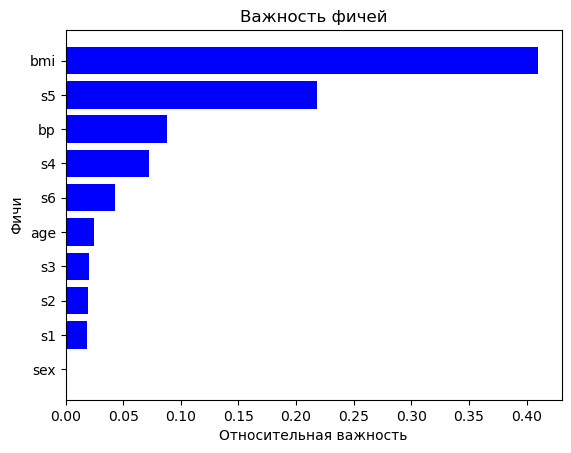

In [6]:
#feature importance
print('Массив feature importance:', '\n', forest.feature_importances())

features = X.columns
importances = forest.feature_importances()
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Важность фичей')
plt.ylabel('Фичи')
plt.xlabel('Относительная важность')
plt.show()

In [7]:
%%capture test
mse_list = []
n_estimators = []
for i in range(1, 21):
    model = MyForestReg(n_estimators=i, max_features=0.66, max_samples=0.66, oob_score='MSE', bins=15)
    model.fit(X_train, y_train)
    y_pred_tree = model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred_tree))
    n_estimators.append(i)

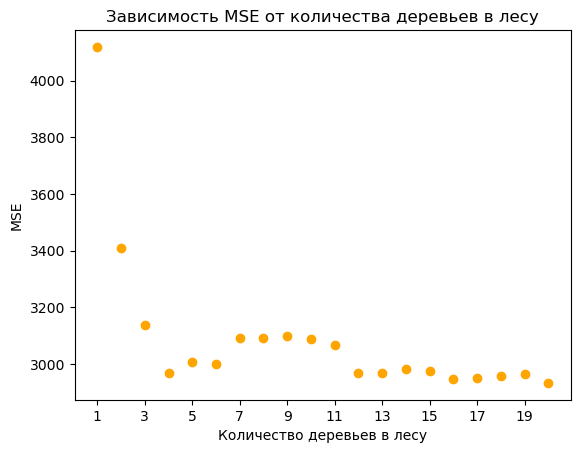

In [8]:
plt.title('Зависимость MSE от количества деревьев в лесу')
plt.scatter(n_estimators, mse_list, color='orange')
plt.xlabel('Количество деревьев в лесу')
plt.ylabel('MSE')
plt.xticks([i for i in range(1, 20, 2)])
plt.show()

### Модель случайного леса, реализованная с использованием sklearn

In [9]:
forest_sklearn = RandomForestRegressor(n_estimators=25, max_depth=5, bootstrap=False)
forest_sklearn.fit(X_train, y_train)
y_pred_sklearn = forest_sklearn.predict(X_test)
print(f'Значение MSE: {mean_squared_error(y_test, y_pred_sklearn)} (sklearn)')

Значение MSE: 3544.0935904000116 (sklearn)


Массив feature importance: 
 [0.03209122 0.00180792 0.5551094  0.02872166 0.06198641 0.02196363
 0.020078   0.03703633 0.18752652 0.05367891]


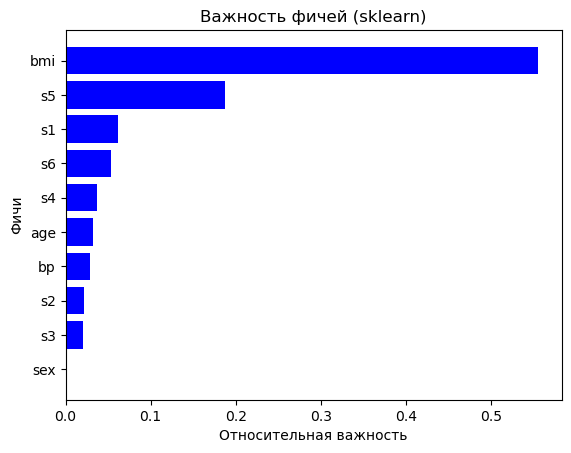

In [12]:
print('Массив feature importance:', '\n', forest_sklearn.feature_importances_)

features = X.columns
importances = forest_sklearn.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Важность фичей (sklearn)')
plt.ylabel('Фичи')
plt.xlabel('Относительная важность')

plt.show()

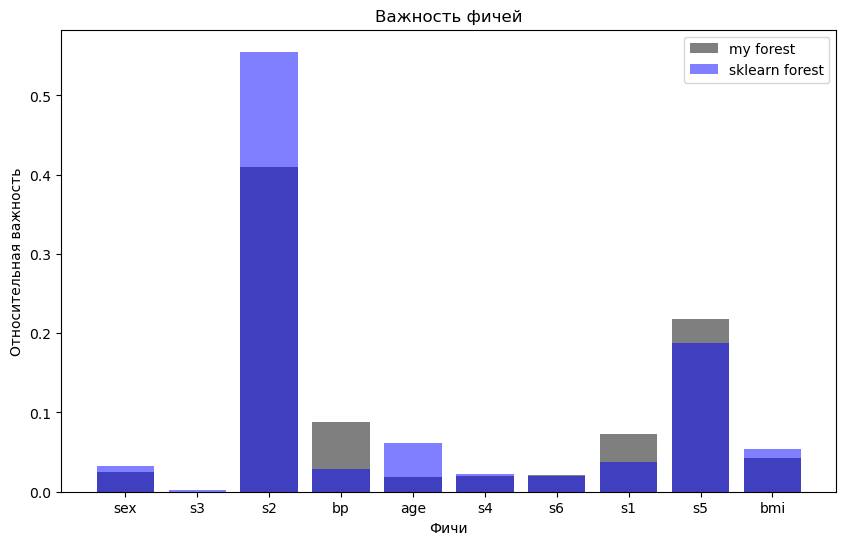

In [13]:
plt.figure(figsize=(10, 6))

my_forest = forest.feature_importances()
sklarn_forest = forest_sklearn.feature_importances_
features = X.columns

importances = forest_sklearn.feature_importances_
indices = np.argsort(importances)

plt.bar([features[i] for i in indices], my_forest,
         color='black', alpha=0.5)

plt.bar([features[i] for i in indices], sklarn_forest,
         color='blue', alpha=0.5)

plt.legend(['my forest', 'sklearn forest'])
plt.title('Важность фичей')
plt.xlabel('Фичи')
plt.ylabel('Относительная важность')

plt.show()